# 1) Imports and Setup

### 1.1) Importing Libraries

In [61]:
import pandas as pd
import numpy as np
import praw
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datetime import datetime, timedelta
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


### 1.2) Downloading NLTK datasets

In [62]:
try:
    nltk.download('punkt', quiet=True) # for tokenization
    nltk.download('vader_lexicon', quiet=True) # lexicon: word dictionary with sentiment score
    nltk.download('stopwords', quiet=True) # list of common irelavnt words (and, as, a,...etc)
    print('✅ NLTK data downloaded successfully!')
except Exception as e:
    print(f"⚠️ NLTK download failed: {e}")
    print("Some text analysis features may not work properly")
    
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))



✅ NLTK data downloaded successfully!


### 1.3) Set up Reddit API connection using config file

In [63]:
import os
from configparser import ConfigParser

def load_reddit_credentials():
    config = ConfigParser()
    
    # Try to load config.ini
    if os.path.exists('config.ini'):
        config.read('config.ini')
        print("✅ Loaded credentials from config.ini")
        
        try:
            client_id = config.get('reddit', 'client_id')
            client_secret = config.get('reddit', 'client_secret')
            user_agent = config.get('reddit', 'user_agent')
            
            # Check if credentials are still placeholder values
            if client_id == "your_client_id_here" or client_secret == "your_client_secret_here":
                raise ValueError("Please update config.ini with your actual credentials")
            
            return client_id, client_secret, user_agent
            
        except Exception as e:
            print(f"❌ Error reading config.ini: {e}")
            return None, None, None
    
    else:
        print("❌ config.ini not found!")
        print("📋 Setup Instructions:")
        print("1. Copy config_template.ini to config.ini")
        print("2. Edit config.ini with your Reddit API credentials")
        print("3. Get credentials at: https://www.reddit.com/prefs/apps")
        return None, None, None

# Load credentials
CLIENT_ID, CLIENT_SECRET, USER_AGENT = load_reddit_credentials()

# Initialize Reddit instance only if credentials are available
if CLIENT_ID and CLIENT_SECRET:
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    
    # Test connection
    try:
        subreddit = reddit.subreddit('cscareerquestions')
        print(f"✅ Successfully connected to Reddit!")
        print(f"📊 r/cscareerquestions has {subreddit.subscribers:,} subscribers")
    except Exception as e:
        print(f"❌ Connection failed: {e}")
        print("Please check your Reddit API credentials in config.ini")
else:
    print("⚠️ Skipping Reddit connection - no credentials available")
    reddit = None

✅ Loaded credentials from config.ini
✅ Successfully connected to Reddit!
📊 r/cscareerquestions has 2,279,481 subscribers


# 2) Data Extraction

### 2.1) Defining Functions

In [64]:
def extract_post_data(post):
    """Extract relevant data from a Reddit post"""
    return {
        'id': post.id,
        'title': post.title,
        'text': post.selftext,
        'score': post.score,
        'upvote_ratio': post.upvote_ratio,
        'num_comments': post.num_comments,
        'created_utc': datetime.fromtimestamp(post.created_utc),
        'author': str(post.author) if post.author else '[deleted]',
        'flair': post.link_flair_text,
        'url': post.url,
        'is_self': post.is_self,
        'gilded': post.gilded,
        'stickied': post.stickied,
        'locked': post.locked
    }


def extract_posts_from_subreddit(limit=10_000, time_filter='year'):
    print(f"🔍 Extracting posts from r/cscareerquestions...")
    
    subreddit = reddit.subreddit('cscareerquestions')
    posts_data = []
    
    posts_per_category = limit // 3
    
    try:
        # Get hot posts
        print(f"📈 Getting {posts_per_category} hot posts...")
        for post in subreddit.hot(limit=posts_per_category):
            posts_data.append(extract_post_data(post))
            
        # Get top posts
        print(f"🔥 Getting {posts_per_category} top posts...")
        for post in subreddit.top(time_filter=time_filter, limit=posts_per_category):
            posts_data.append(extract_post_data(post))
            
        # Get new posts
        print(f"🆕 Getting {posts_per_category} new posts...")
        for post in subreddit.new(limit=posts_per_category):
            posts_data.append(extract_post_data(post))
    
    except Exception as e:
        print(f"❌ Error extracting posts: {e}")
        return None
    
    
    # Remove duplicates based on post ID
    seen_ids = set()
    unique_posts = []
    for post in posts_data:
        if post['id'] not in seen_ids:
            seen_ids.add(post['id'])
            unique_posts.append(post)
    
    print(f"✅ Successfully extracted {len(unique_posts)} unique posts")
    return pd.DataFrame(unique_posts)

print("✅ Data extraction functions defined!")

✅ Data extraction functions defined!


### 2.2) Run the data extraction

In [65]:
# Extract posts 
posts_df = extract_posts_from_subreddit(limit=10_000, time_filter='year')

if posts_df is not None and len(posts_df) > 0:
    print(f"\n📊 Dataset created successfully!")
    print(f"Shape: {posts_df.shape}")
    print(f"Date range: {posts_df['created_utc'].min()} to {posts_df['created_utc'].max()}")
    
    # Display first few rows
    print("\n👀 First 3 posts preview:")
    display(posts_df[['title', 'score', 'num_comments', 'created_utc']].head(3))
else:
    print("❌ Failed to extract data. Please check your Reddit API setup.")

🔍 Extracting posts from r/cscareerquestions...
📈 Getting 3333 hot posts...
🔥 Getting 3333 top posts...
🆕 Getting 3333 new posts...
✅ Successfully extracted 1230 unique posts

📊 Dataset created successfully!
Shape: (1230, 14)
Date range: 2024-09-26 22:13:27 to 2025-09-25 10:25:28

👀 First 3 posts preview:


,title,score,num_comments,created_utc
0,"Interview Discussion - September 25, 2025",1,0,2025-09-25 10:00:33
1,[OFFICIAL] Salary Sharing thread for NEW GRADS...,25,17,2025-09-16 10:02:30
2,Is tech job market really cooked ?,123,63,2025-09-25 06:10:48


### 2.3) Basic Overview of the Dataset

In [66]:
if posts_df is not None and len(posts_df) > 0:
    print("=" * 50)
    print("📊 BASIC STATISTICS")
    print("=" * 50)
    
    print(f"Total posts: {len(posts_df):,}")
    print(f"Unique authors: {posts_df['author'].nunique():,}")
    print(f"Date range: {posts_df['created_utc'].min().strftime('%Y-%m-%d')} to {posts_df['created_utc'].max().strftime('%Y-%m-%d')}")
    
    # Engagement metrics
    print(f"\n💬 Engagement Metrics:")
    print(f"Average score: {posts_df['score'].mean():.1f}")
    print(f"Median score: {posts_df['score'].median():.1f}")
    print(f"Average comments: {posts_df['num_comments'].mean():.1f}")
    print(f"Average upvote ratio: {posts_df['upvote_ratio'].mean():.3f}")
    
    # Top authors
    print(f"\n👑 Most Active Authors:")
    top_authors = posts_df['author'].value_counts().head(10)
    for author, count in top_authors.items():
        print(f"  {author}: {count} posts")
    
    # Post flairs
    if posts_df['flair'].notna().sum() > 0:
        print(f"\n🏷️ Most Common Post Flairs:")
        flair_counts = posts_df['flair'].value_counts().dropna().head(8)
        for flair, count in flair_counts.items():
            percentage = (count / len(posts_df)) * 100
            print(f"  {flair}: {count} posts ({percentage:.1f}%)")
    
    # Basic data info
    print(f"\n📋 Data Info:")
    print(f"Missing values in title: {posts_df['title'].isna().sum()}")
    print(f"Missing values in text: {posts_df['text'].isna().sum()}")
    print(f"Self posts: {posts_df['is_self'].sum()} ({posts_df['is_self'].mean()*100:.1f}%)")

📊 BASIC STATISTICS
Total posts: 1,230
Unique authors: 996
Date range: 2024-09-26 to 2025-09-25

💬 Engagement Metrics:
Average score: 340.0
Median score: 5.0
Average comments: 90.4
Average upvote ratio: 0.730

👑 Most Active Authors:
  CSCQMods: 27 posts
  [deleted]: 15 posts
  cs-grad-person-man: 13 posts
  metalreflectslime: 12 posts
  oppalissa: 9 posts
  Particular_World_934: 7 posts
  MarathonMarathon: 7 posts
  Legitimate-mostlet: 6 posts
  ContainerDesk: 6 posts
  Ok-Cartographer-5544: 6 posts

🏷️ Most Common Post Flairs:
  Experienced: 213 posts (17.3%)
  Student: 133 posts (10.8%)
  New Grad: 118 posts (9.6%)
  Meta: 21 posts (1.7%)
  Lead/Manager: 9 posts (0.7%)

📋 Data Info:
Missing values in title: 0
Missing values in text: 0
Self posts: 1230 (100.0%)


# 3) Temporal Analysis

### 3.1) Prepare data for temporal analysis

In [67]:
if posts_df is not None and len(posts_df) > 0:
    # Add time-based columns
    posts_df['hour'] = posts_df['created_utc'].dt.hour
    posts_df['day_of_week'] = posts_df['created_utc'].dt.day_name()
    posts_df['date'] = posts_df['created_utc'].dt.date
    posts_df['month'] = posts_df['created_utc'].dt.to_period('M')
    
    print("✅ Temporal columns added successfully!")
    print(f"Hour range: {posts_df['hour'].min()} to {posts_df['hour'].max()} hours.")
    print(f"Day range: {posts_df['day_of_week'].unique()}")

✅ Temporal columns added successfully!
Hour range: 0 to 23 hours.
Day range: ['Thursday' 'Tuesday' 'Wednesday' 'Monday' 'Sunday' 'Saturday' 'Friday']


### 3.2) Visualize posting patterns over time

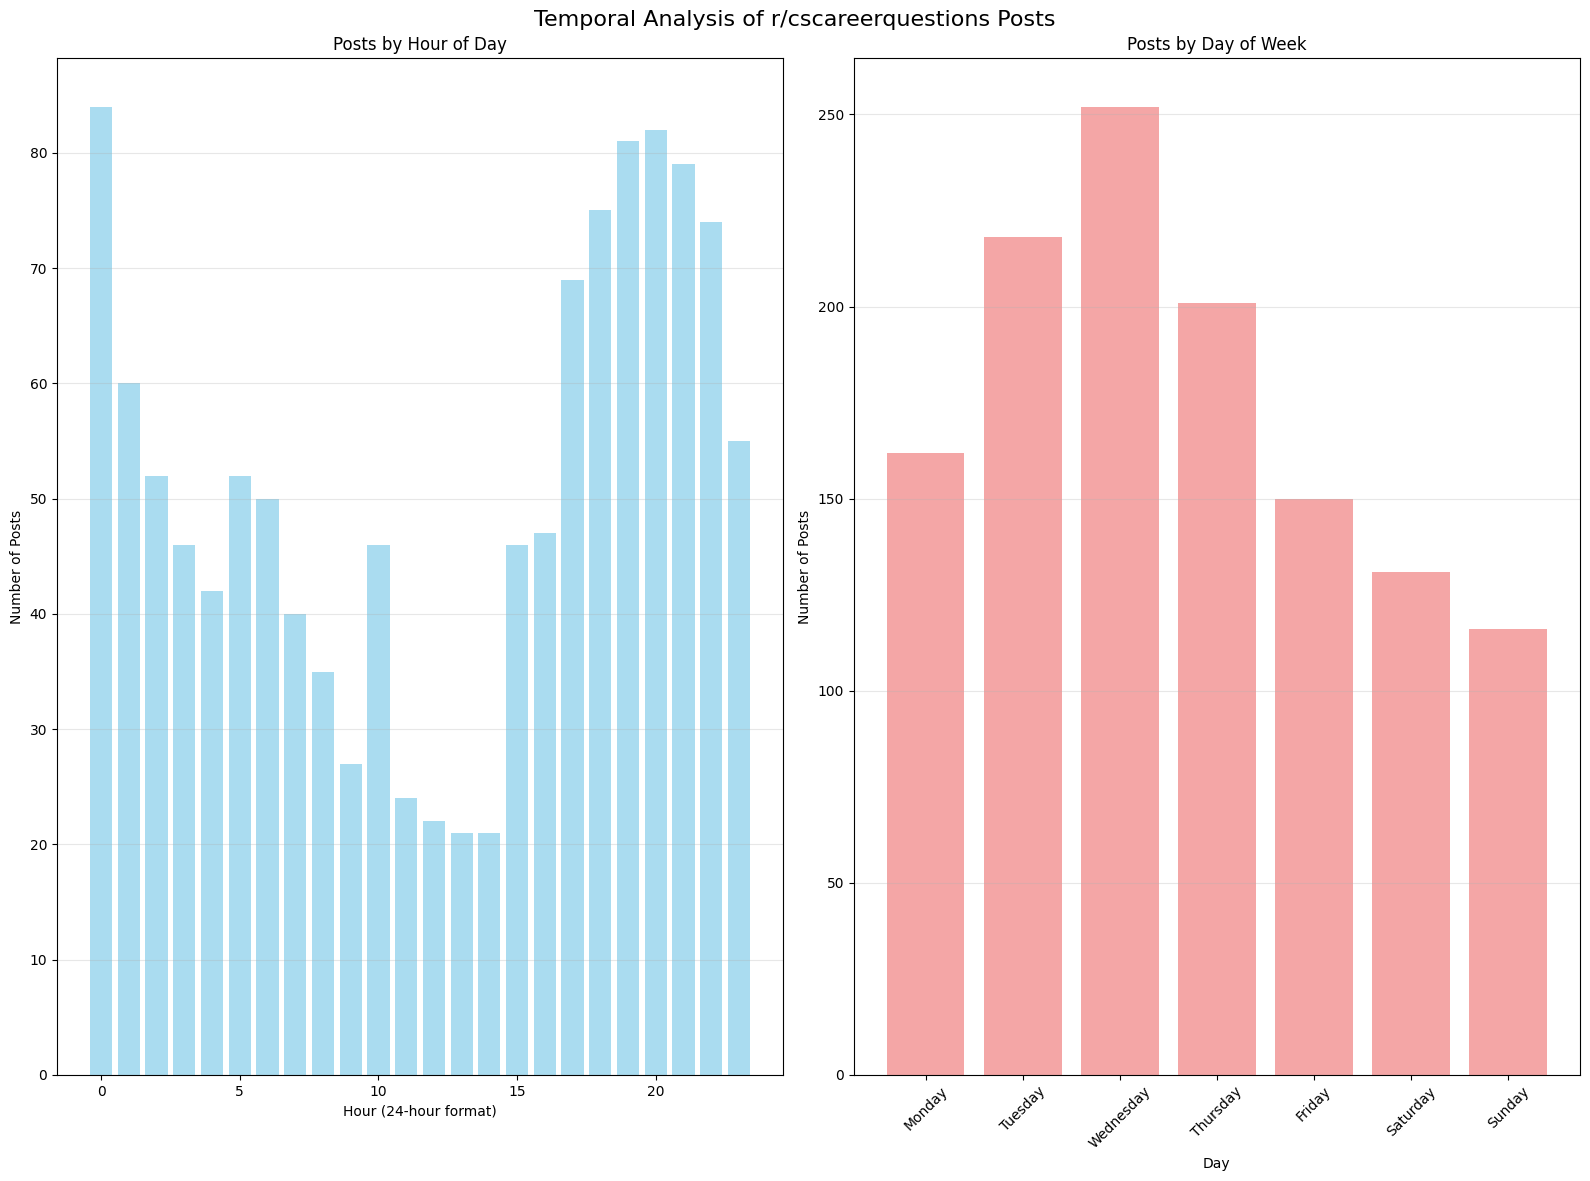

📈 Peak posting hour: 0:00
📈 Most active day: Wednesday


In [68]:
if posts_df is not None and len(posts_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    fig.suptitle('Temporal Analysis of r/cscareerquestions Posts', fontsize=16)
    
    # Posts by hour of day
    hourly_counts = posts_df['hour'].value_counts().sort_index()
    axes[0].bar(hourly_counts.index, hourly_counts.values, color='skyblue', alpha=0.7)
    axes[0].set_title('Posts by Hour of Day')
    axes[0].set_xlabel('Hour (24-hour format)')
    axes[0].set_ylabel('Number of Posts')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Posts by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_counts = posts_df['day_of_week'].value_counts().reindex(day_order)
    axes[1].bar(range(len(daily_counts)), daily_counts.values, color='lightcoral', alpha=0.7)
    axes[1].set_title('Posts by Day of Week')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Number of Posts')
    axes[1].set_xticks(range(len(day_order)))
    axes[1].set_xticklabels(day_order, rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    

    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    peak_hour = posts_df['hour'].mode()[0]
    peak_day = posts_df['day_of_week'].mode()[0]
    print(f"📈 Peak posting hour: {peak_hour}:00")
    print(f"📈 Most active day: {peak_day}")


# 4) Analyze user engagement metrics

### 4.1) Score to Comment/ Upvote Correlation Ratios

In [69]:
if posts_df is not None and len(posts_df) > 0:
    # Calculate engagement metrics
    posts_df['comments_per_score'] = posts_df['num_comments'] / (posts_df['score'] + 1)  # +1 to avoid division by zero
    posts_df['engagement_ratio'] = posts_df['num_comments'] * posts_df['upvote_ratio']
    
    # Find correlations
    score_comments_corr = posts_df['score'].corr(posts_df['num_comments'])
    score_ratio_corr = posts_df['score'].corr(posts_df['upvote_ratio'])
    
    print("✅ Engagement metrics calculated!")
    print(f"Score-Comments correlation: {score_comments_corr:.3f}")
    print(f"Score-Upvote ratio correlation: {score_ratio_corr:.3f}")


✅ Engagement metrics calculated!
Score-Comments correlation: 0.853
Score-Upvote ratio correlation: 0.326


### 4.2) Visualize engagement patterns

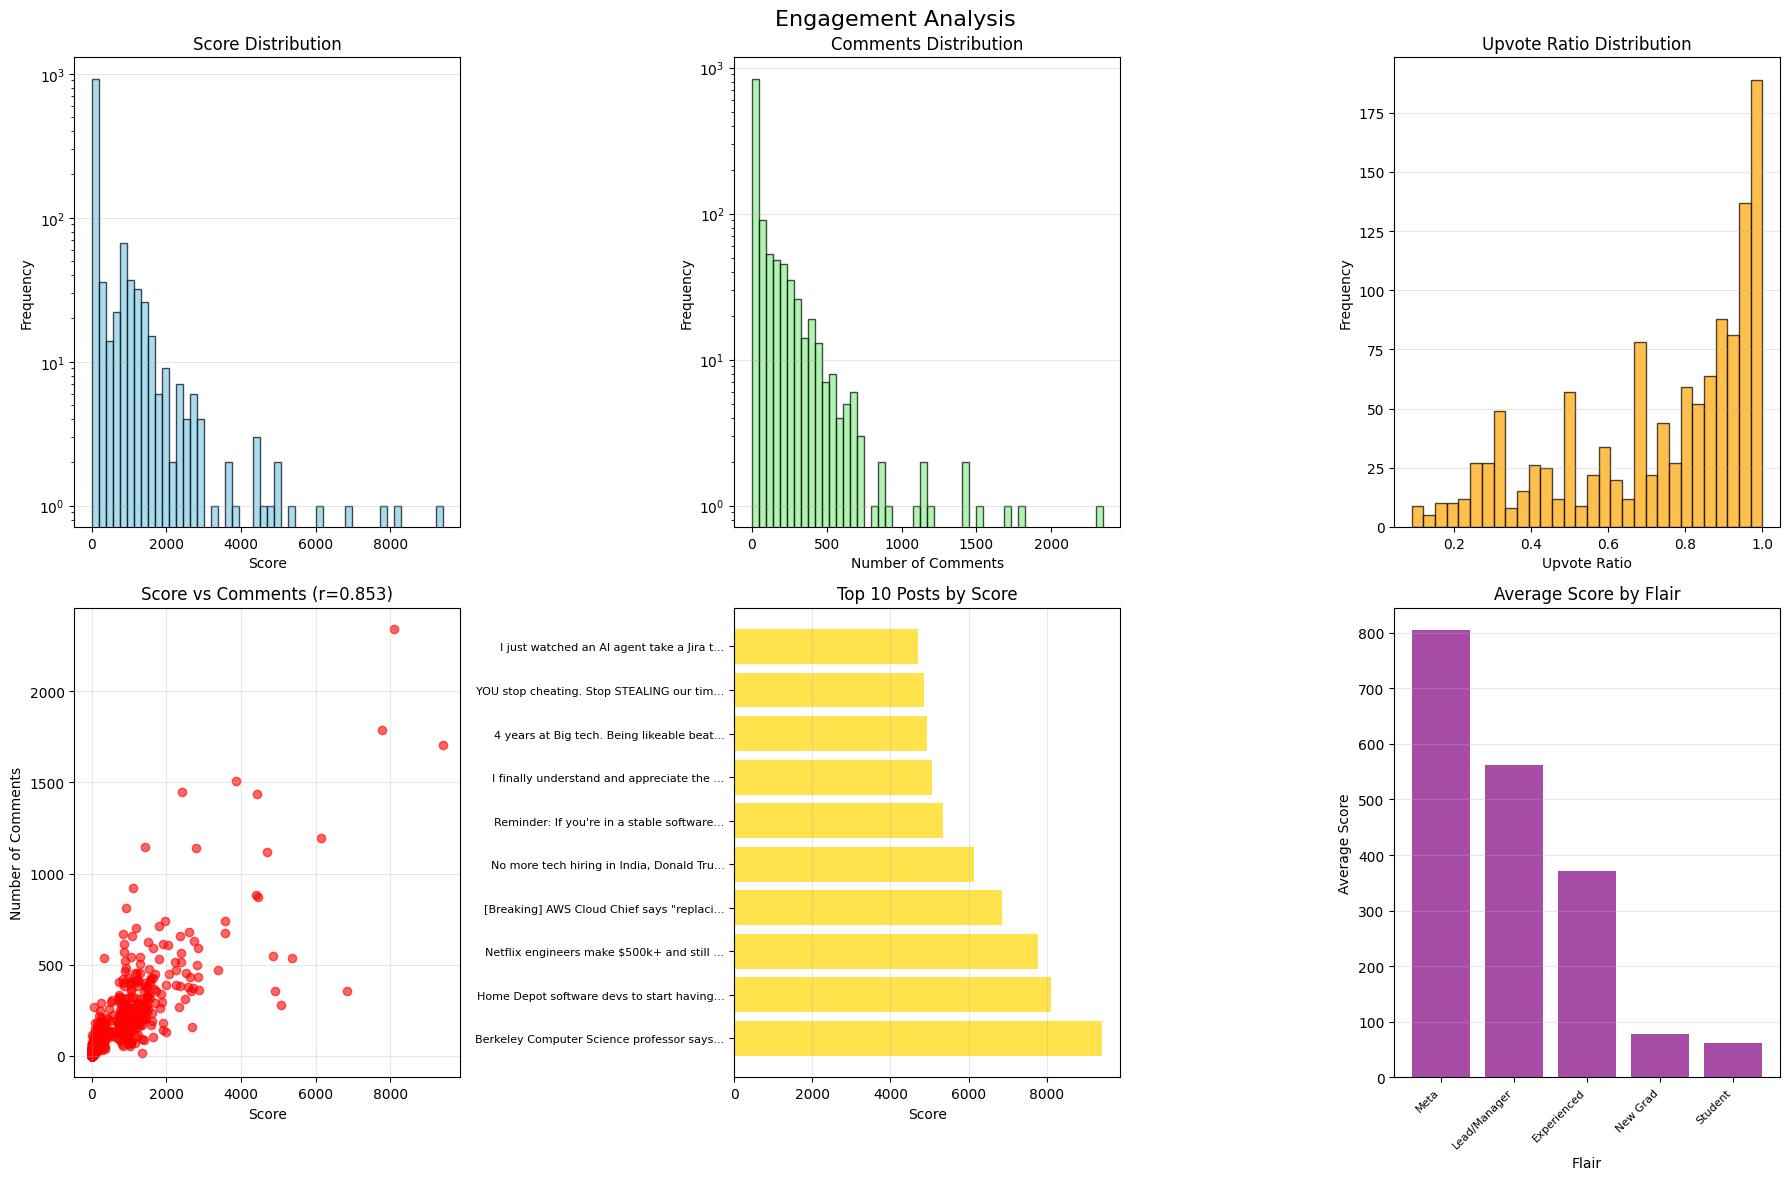

In [70]:
if posts_df is not None and len(posts_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Engagement Analysis', fontsize=16)
    
    # Score distribution
    axes[0, 0].hist(posts_df['score'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Score Distribution')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Comments distribution
    axes[0, 1].hist(posts_df['num_comments'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Comments Distribution')
    axes[0, 1].set_xlabel('Number of Comments')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Upvote ratio distribution
    axes[0, 2].hist(posts_df['upvote_ratio'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 2].set_title('Upvote Ratio Distribution')
    axes[0, 2].set_xlabel('Upvote Ratio')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(axis='y', alpha=0.3)
    
    # Score vs Comments scatter
    axes[1, 0].scatter(posts_df['score'], posts_df['num_comments'], alpha=0.6, color='red')
    axes[1, 0].set_title(f'Score vs Comments (r={score_comments_corr:.3f})')
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].set_ylabel('Number of Comments')
    axes[1, 0].grid(alpha=0.3)
    
    # Top posts by score
    top_posts = posts_df.nlargest(10, 'score')[['title', 'score']].copy()
    top_posts['title_short'] = top_posts['title'].str[:40] + '...'
    
    y_pos = np.arange(len(top_posts))
    axes[1, 1].barh(y_pos, top_posts['score'], color='gold', alpha=0.7)
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels(top_posts['title_short'], fontsize=8)
    axes[1, 1].set_title('Top 10 Posts by Score')
    axes[1, 1].set_xlabel('Score')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    # Engagement by flair (if available)
    if posts_df['flair'].notna().sum() > 5:  # Only if we have enough flaired posts
        flair_engagement = posts_df.groupby('flair')['score'].mean().dropna().sort_values(ascending=False).head(8)
        axes[1, 2].bar(range(len(flair_engagement)), flair_engagement.values, color='purple', alpha=0.7)
        axes[1, 2].set_title('Average Score by Flair')
        axes[1, 2].set_xlabel('Flair')
        axes[1, 2].set_ylabel('Average Score')
        axes[1, 2].set_xticks(range(len(flair_engagement)))
        axes[1, 2].set_xticklabels(flair_engagement.index, rotation=45, ha='right', fontsize=8)
        axes[1, 2].grid(axis='y', alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'Not enough\nflaired posts\nfor analysis', 
                        ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('Flair Analysis')
    
    plt.tight_layout()
    plt.show()


# 5) Text-Data Analysis

### 5.1) Prepare text data for analysis

In [71]:
if posts_df is not None and len(posts_df) > 0:
    # Combine title and text for comprehensive analysis
    posts_df['combined_text'] = posts_df['title'] + ' ' + posts_df['text'].fillna('')
    
    # Calculate text lengths
    posts_df['title_length'] = posts_df['title'].str.len()
    posts_df['text_length'] = posts_df['text'].fillna('').str.len()
    posts_df['combined_length'] = posts_df['combined_text'].str.len()
    
    print("✅ Text columns prepared!")
    print(f"Average title length: {posts_df['title_length'].mean():.1f} characters")
    print(f"Average text length: {posts_df['text_length'].mean():.1f} characters")
    print(f"Posts with text content: {(posts_df['text_length'] > 0).sum()} ({(posts_df['text_length'] > 0).mean()*100:.1f}%)")

✅ Text columns prepared!
Average title length: 59.8 characters
Average text length: 951.0 characters
Posts with text content: 1230 (100.0%)


### 5.2) Perform sentiment analysis on the posts

In [72]:
if posts_df is not None and len(posts_df) > 0:
    print("🔍 Performing sentiment analysis...")
    print("This might take a moment...")
    
    # Calculate sentiment scores
    sentiment_scores = []
    for i, text in enumerate(posts_df['combined_text']):
        if i % 100 == 0:  # Progress indicator
            print(f"  Processed {i}/{len(posts_df)} posts...")
        
        sentiment = sia.polarity_scores(text)
        sentiment_scores.append(sentiment)
    
    # Add sentiment columns to dataframe
    sentiment_df = pd.DataFrame(sentiment_scores)
    posts_df = pd.concat([posts_df, sentiment_df], axis=1)
    
    print("✅ Sentiment analysis completed!")
    print(f"Average sentiment (compound): {posts_df['compound'].mean():.3f}")
    
    # Categorize sentiments
    posts_df['sentiment_category'] = pd.cut(posts_df['compound'], 
                                            bins=[-1, -0.05, 0.05, 1], 
                                            labels=['Negative', 'Neutral', 'Positive'])
    
    print(f"\nSentiment distribution:")
    sentiment_dist = posts_df['sentiment_category'].value_counts()
    for sentiment, count in sentiment_dist.items():
        percentage = (count / len(posts_df)) * 100
        print(f"  {sentiment}: {count} posts ({percentage:.1f}%)")


🔍 Performing sentiment analysis...
This might take a moment...
  Processed 0/1230 posts...
  Processed 100/1230 posts...
  Processed 200/1230 posts...
  Processed 300/1230 posts...
  Processed 400/1230 posts...
  Processed 500/1230 posts...
  Processed 600/1230 posts...
  Processed 700/1230 posts...
  Processed 800/1230 posts...
  Processed 900/1230 posts...
  Processed 1000/1230 posts...
  Processed 1100/1230 posts...
  Processed 1200/1230 posts...
✅ Sentiment analysis completed!
Average sentiment (compound): 0.371

Sentiment distribution:
  Positive: 850 posts (69.1%)
  Negative: 327 posts (26.6%)
  Neutral: 53 posts (4.3%)


### 5.3) Visualize sentiment analysis results

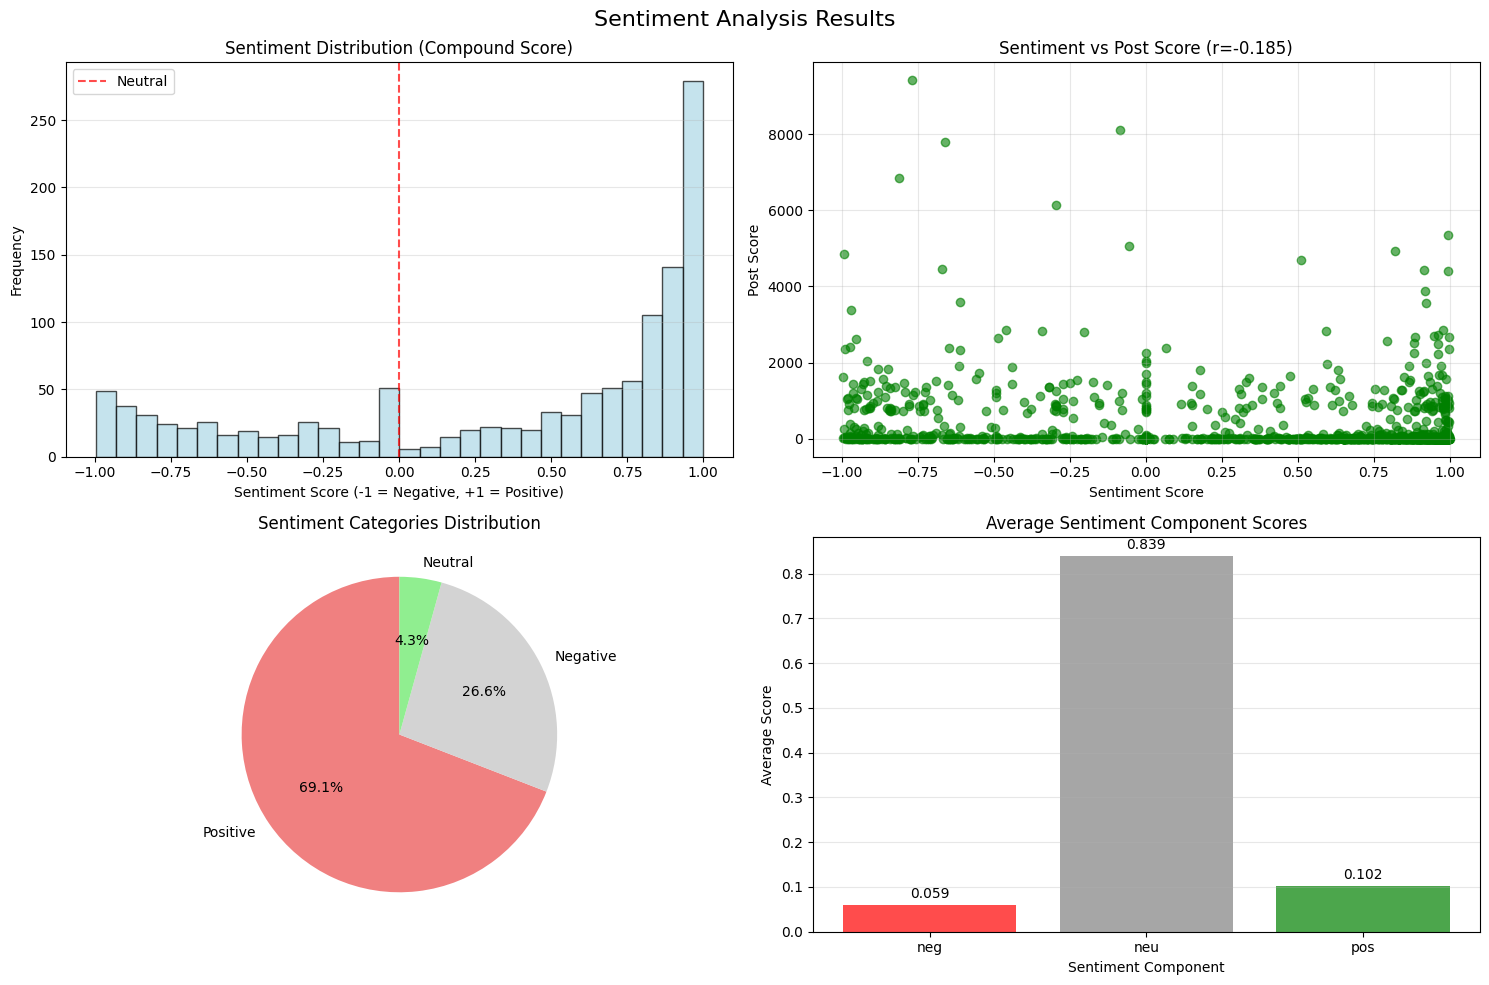

📊 SENTIMENT INSIGHTS:
Most positive post: Cant seem to "stick" with a CS career choice?...
  Sentiment score: 0.999
Most negative post: I'm planning to trash my Software Development career after 7 years. Here's why:...
  Sentiment score: -0.996


In [73]:
if posts_df is not None and 'compound' in posts_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sentiment Analysis Results', fontsize=16)
    
    # Sentiment distribution histogram
    axes[0, 0].hist(posts_df['compound'], bins=30, edgecolor='black', alpha=0.7, color='lightblue')
    axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    axes[0, 0].set_title('Sentiment Distribution (Compound Score)')
    axes[0, 0].set_xlabel('Sentiment Score (-1 = Negative, +1 = Positive)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Sentiment vs Score scatter
    sentiment_score_corr = posts_df['compound'].corr(posts_df['score'])
    axes[0, 1].scatter(posts_df['compound'], posts_df['score'], alpha=0.6, color='green')
    axes[0, 1].set_title(f'Sentiment vs Post Score (r={sentiment_score_corr:.3f})')
    axes[0, 1].set_xlabel('Sentiment Score')
    axes[0, 1].set_ylabel('Post Score')
    axes[0, 1].grid(alpha=0.3)
    
    # Sentiment categories pie chart
    sentiment_counts = posts_df['sentiment_category'].value_counts()
    colors = ['lightcoral', 'lightgray', 'lightgreen']
    axes[1, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                    colors=colors, startangle=90)
    axes[1, 0].set_title('Sentiment Categories Distribution')
    
    # Sentiment breakdown bar chart
    sentiment_categories = ['neg', 'neu', 'pos']
    sentiment_means = [posts_df[cat].mean() for cat in sentiment_categories]
    bars = axes[1, 1].bar(sentiment_categories, sentiment_means, color=['red', 'gray', 'green'], alpha=0.7)
    axes[1, 1].set_title('Average Sentiment Component Scores')
    axes[1, 1].set_ylabel('Average Score')
    axes[1, 1].set_xlabel('Sentiment Component')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, sentiment_means):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print most positive and negative posts
    print("📊 SENTIMENT INSIGHTS:")
    print(f"Most positive post: {posts_df.loc[posts_df['compound'].idxmax(), 'title'][:80]}...")
    print(f"  Sentiment score: {posts_df['compound'].max():.3f}")
    print(f"Most negative post: {posts_df.loc[posts_df['compound'].idxmin(), 'title'][:80]}...")
    print(f"  Sentiment score: {posts_df['compound'].min():.3f}")


### 5.4) Analyze text length patterns

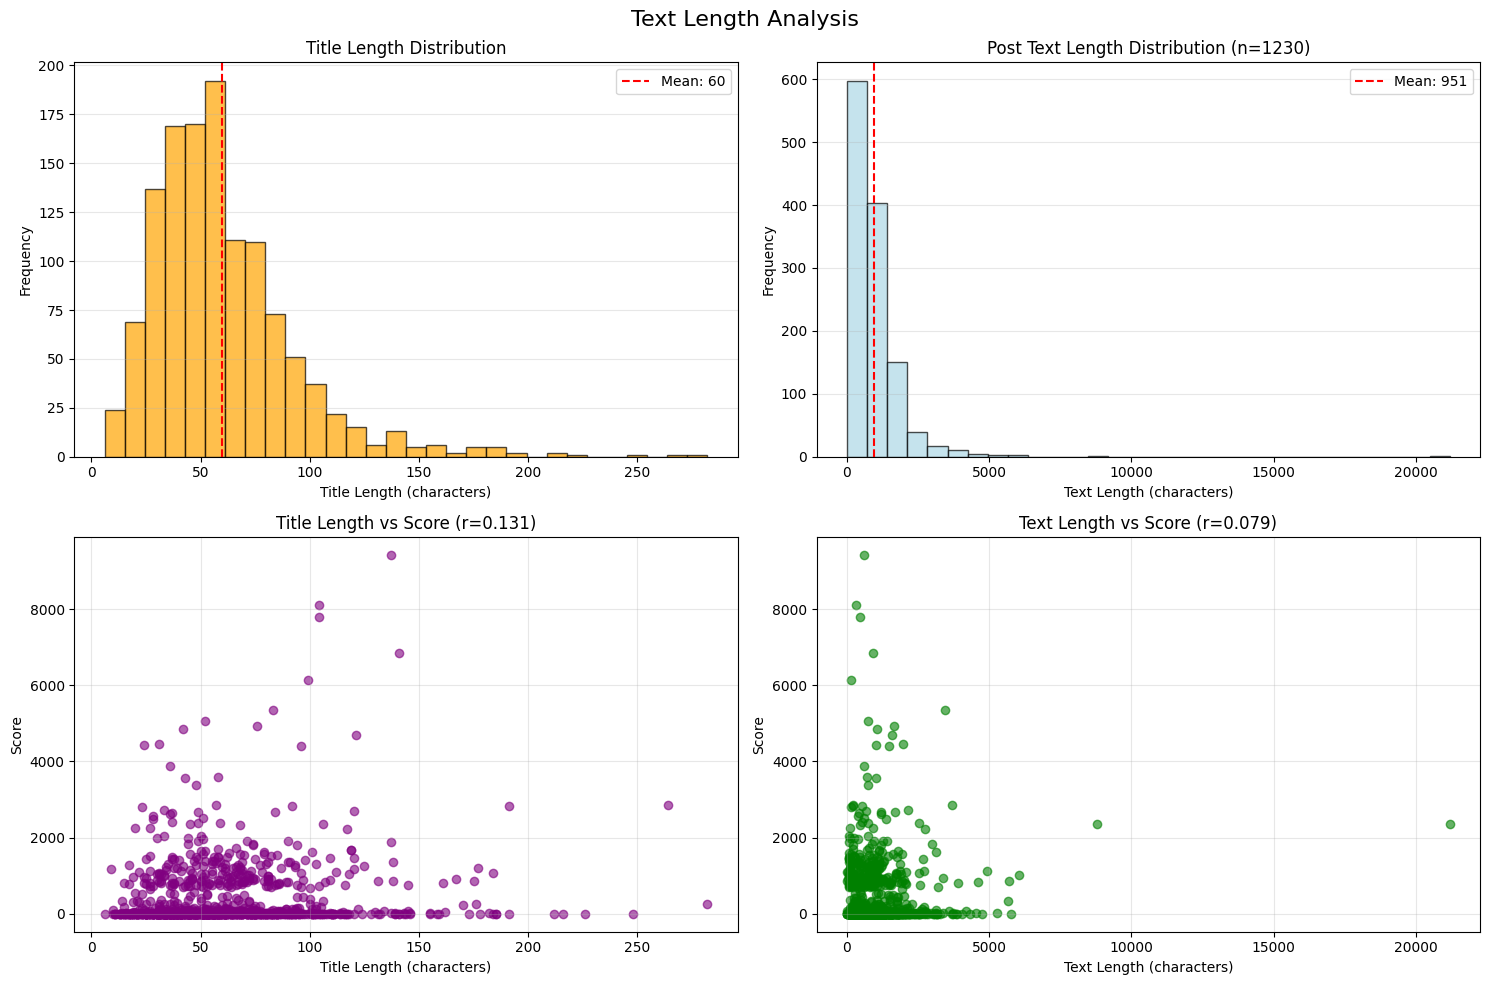

📏 TEXT LENGTH STATISTICS:
Average title length: 59.8 characters
Median title length: 54.0 characters
Average text length (posts with content): 951.0 characters
Median text length (posts with content): 738.0 characters


In [74]:
if posts_df is not None and len(posts_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Text Length Analysis', fontsize=16)
    
    # Title length distribution
    axes[0, 0].hist(posts_df['title_length'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 0].set_title('Title Length Distribution')
    axes[0, 0].set_xlabel('Title Length (characters)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(posts_df['title_length'].mean(), color='red', linestyle='--', 
                        label=f'Mean: {posts_df["title_length"].mean():.0f}')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Text length distribution (excluding empty posts)
    text_with_content = posts_df[posts_df['text_length'] > 0]['text_length']
    if len(text_with_content) > 0:
        axes[0, 1].hist(text_with_content, bins=30, edgecolor='black', alpha=0.7, color='lightblue')
        axes[0, 1].set_title(f'Post Text Length Distribution (n={len(text_with_content)})')
        axes[0, 1].set_xlabel('Text Length (characters)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].axvline(text_with_content.mean(), color='red', linestyle='--', 
                            label=f'Mean: {text_with_content.mean():.0f}')
        axes[0, 1].legend()
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Title length vs Score
    title_score_corr = posts_df['title_length'].corr(posts_df['score'])
    axes[1, 0].scatter(posts_df['title_length'], posts_df['score'], alpha=0.6, color='purple')
    axes[1, 0].set_title(f'Title Length vs Score (r={title_score_corr:.3f})')
    axes[1, 0].set_xlabel('Title Length (characters)')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].grid(alpha=0.3)
    
    # Text length vs Score (for posts with text)
    posts_with_text = posts_df[posts_df['text_length'] > 0]
    if len(posts_with_text) > 10:
        text_score_corr = posts_with_text['text_length'].corr(posts_with_text['score'])
        axes[1, 1].scatter(posts_with_text['text_length'], posts_with_text['score'], alpha=0.6, color='green')
        axes[1, 1].set_title(f'Text Length vs Score (r={text_score_corr:.3f})')
        axes[1, 1].set_xlabel('Text Length (characters)')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📏 TEXT LENGTH STATISTICS:")
    print(f"Average title length: {posts_df['title_length'].mean():.1f} characters")
    print(f"Median title length: {posts_df['title_length'].median():.1f} characters")
    if len(text_with_content) > 0:
        print(f"Average text length (posts with content): {text_with_content.mean():.1f} characters")
        print(f"Median text length (posts with content): {text_with_content.median():.1f} characters")


### 5.5) Prepare for keyword analysis

In [75]:
if posts_df is not None and len(posts_df) > 0:
    def clean_text(text):
        """Clean text for analysis"""
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    
    def get_meaningful_words(text_series, min_length=3):
        """Extract meaningful words from text"""
        all_text = ' '.join(text_series.fillna(''))
        clean_text_content = clean_text(all_text)
        
        # Tokenize and filter
        words = [word for word in word_tokenize(clean_text_content) 
                if word not in stop_words and len(word) >= min_length]
        
        return words
    
    # Extract words from titles and posts
    print("🔤 Extracting keywords...")
    title_words = get_meaningful_words(posts_df['title'])
    text_words = get_meaningful_words(posts_df['text'])
    
    # Count word frequencies
    title_counter = Counter(title_words)
    text_counter = Counter(text_words)
    
    print(f"✅ Found {len(title_counter)} unique words in titles")
    print(f"✅ Found {len(text_counter)} unique words in post text")
    
    print("\n🔍 Most common words in titles:")
    for word, count in title_counter.most_common(10):
        print(f"  {word}: {count}")

🔤 Extracting keywords...
✅ Found 2361 unique words in titles
✅ Found 10630 unique words in post text

🔍 Most common words in titles:
  job: 161
  tech: 81
  get: 74
  career: 70
  advice: 61
  new: 60
  need: 49
  jobs: 47
  work: 47
  software: 46


### 5.6) Create word frequency visualizations and word clouds


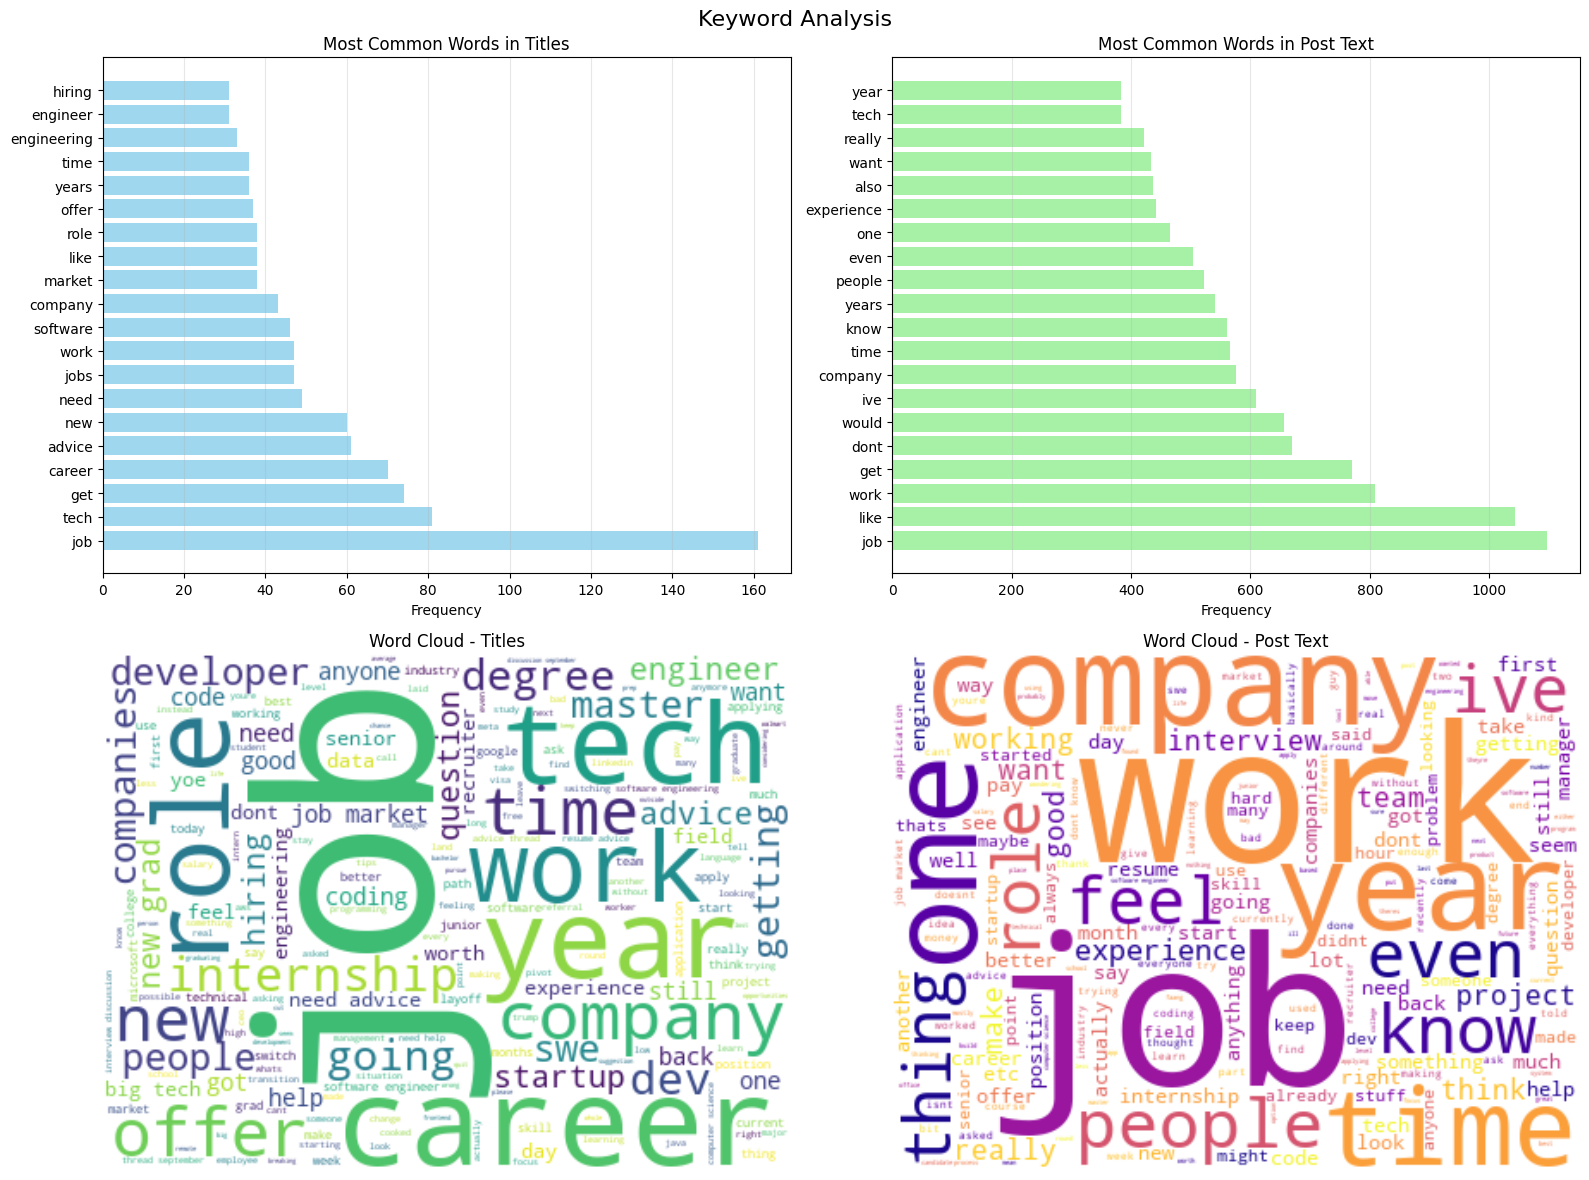

In [76]:
if posts_df is not None and len(title_words) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Keyword Analysis', fontsize=16)
    
    # Most common words in titles
    common_title_words = title_counter.most_common(20)
    words, counts = zip(*common_title_words)
    y_pos = np.arange(len(words))
    
    axes[0, 0].barh(y_pos, counts, color='skyblue', alpha=0.8)
    axes[0, 0].set_yticks(y_pos)
    axes[0, 0].set_yticklabels(words)
    axes[0, 0].set_title('Most Common Words in Titles')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Most common words in text
    if len(text_counter) > 0:
        common_text_words = text_counter.most_common(20)
        if common_text_words:
            words_text, counts_text = zip(*common_text_words)
            y_pos_text = np.arange(len(words_text))
            
            axes[0, 1].barh(y_pos_text, counts_text, color='lightgreen', alpha=0.8)
            axes[0, 1].set_yticks(y_pos_text)
            axes[0, 1].set_yticklabels(words_text)
            axes[0, 1].set_title('Most Common Words in Post Text')
            axes[0, 1].set_xlabel('Frequency')
            axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Word cloud for titles
    if title_words:
        wordcloud_titles = WordCloud(width=400, height=300, 
                                    background_color='white',
                                    colormap='viridis').generate(' '.join(title_words))
        axes[1, 0].imshow(wordcloud_titles, interpolation='bilinear')
        axes[1, 0].axis('off')
        axes[1, 0].set_title('Word Cloud - Titles')
    
    # Word cloud for text
    if text_words and len(text_words) > 10:
        wordcloud_text = WordCloud(width=400, height=300, 
                                background_color='white',
                                colormap='plasma').generate(' '.join(text_words))
        axes[1, 1].imshow(wordcloud_text, interpolation='bilinear')
        axes[1, 1].axis('off')
        axes[1, 1].set_title('Word Cloud - Post Text')
    else:
        axes[1, 1].text(0.5, 0.5, 'Not enough\ntext content\nfor word cloud', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Word Cloud - Post Text')
    
    plt.tight_layout()
    plt.show()

### 5.7) Analyze career-specific topics and trends

🔍 Analyzing career topics...
  Job Search: 1777 mentions
  Salary & Compensation: 477 mentions
  Experience Level: 1237 mentions
  Education: 686 mentions
  Technology: 402 mentions
  Company Types: 1266 mentions
  Career Change: 291 mentions
  Remote Work: 139 mentions

💰 Salary Posts Analysis:
  Posts mentioning salary: 257 (20.9%)
  Average score: 314.5 vs 340.0 (all posts)

📝 Interview Posts Analysis:
  Posts mentioning interviews: 346 (28.1%)
  Average comments: 90.9 vs 90.4 (all posts)


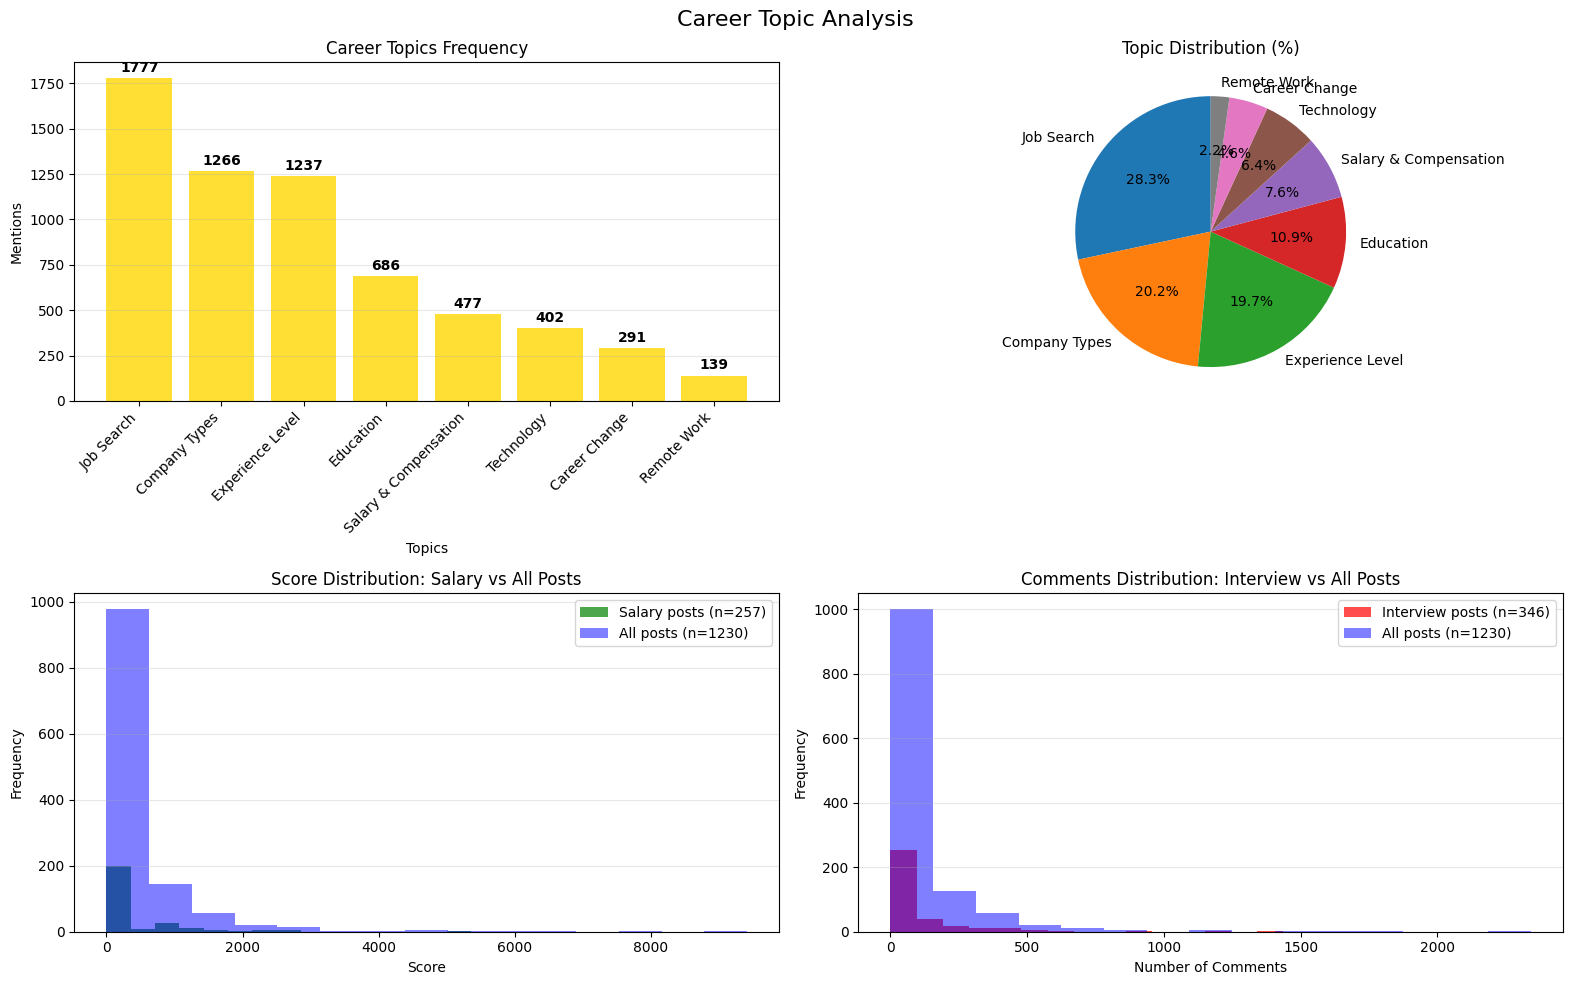

In [77]:
if posts_df is not None and len(posts_df) > 0:
    # Define career-related keyword categories
    career_keywords = {
        'Job Search': ['job', 'interview', 'application', 'resume', 'cv', 'hiring', 'career', 'apply'],
        'Salary & Compensation': ['salary', 'pay', 'compensation', 'money', 'wage', 'income', 'raise', 'bonus'],
        'Experience Level': ['experience', 'junior', 'senior', 'entry level', 'years', 'beginner', 'intern'],
        'Education': ['degree', 'bootcamp', 'college', 'university', 'education', 'learn', 'study', 'course'],
        'Technology': ['python', 'java', 'javascript', 'react', 'aws', 'cloud', 'frontend', 'backend', 'sql'],
        'Company Types': ['company', 'startup', 'corporation', 'faang', 'big tech', 'work', 'workplace'],
        'Career Change': ['switch', 'transition', 'change', 'pivot', 'career change', 'different field'],
        'Remote Work': ['remote', 'wfh', 'work from home', 'hybrid', 'location', 'relocate']
    }
    
    # Count keyword occurrences in combined text
    combined_text_lower = posts_df['combined_text'].str.lower()
    topic_counts = {}
    
    print("🔍 Analyzing career topics...")
    for category, keywords in career_keywords.items():
        count = 0
        for keyword in keywords:
            count += combined_text_lower.str.contains(keyword, case=False, na=False).sum()
        topic_counts[category] = count
        print(f"  {category}: {count} mentions")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Career Topic Analysis', fontsize=16)
    
    # Topic frequency bar chart
    topics, counts = zip(*sorted(topic_counts.items(), key=lambda x: x[1], reverse=True))
    
    bars = axes[0, 0].bar(range(len(topics)), counts, color='gold', alpha=0.8)
    axes[0, 0].set_title('Career Topics Frequency')
    axes[0, 0].set_xlabel('Topics')
    axes[0, 0].set_ylabel('Mentions')
    axes[0, 0].set_xticks(range(len(topics)))
    axes[0, 0].set_xticklabels(topics, rotation=45, ha='right')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                        str(count), ha='center', va='bottom', fontweight='bold')
    
    # Topic percentage pie chart
    axes[0, 1].pie(counts, labels=topics, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Topic Distribution (%)')
    
    # Analyze salary-related posts
    salary_mask = combined_text_lower.str.contains('salary|pay|compensation', case=False, na=False)
    salary_posts = posts_df[salary_mask]
    
    if len(salary_posts) > 5:
        axes[1, 0].hist(salary_posts['score'], bins=15, alpha=0.7, label=f'Salary posts (n={len(salary_posts)})', color='green')
        axes[1, 0].hist(posts_df['score'], bins=15, alpha=0.5, label=f'All posts (n={len(posts_df)})', color='blue')
        axes[1, 0].set_title('Score Distribution: Salary vs All Posts')
        axes[1, 0].set_xlabel('Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        print(f"\n💰 Salary Posts Analysis:")
        print(f"  Posts mentioning salary: {len(salary_posts)} ({len(salary_posts)/len(posts_df)*100:.1f}%)")
        print(f"  Average score: {salary_posts['score'].mean():.1f} vs {posts_df['score'].mean():.1f} (all posts)")
    
    # Analyze interview-related posts
    interview_mask = combined_text_lower.str.contains('interview|hiring', case=False, na=False)
    interview_posts = posts_df[interview_mask]
    
    if len(interview_posts) > 5:
        axes[1, 1].hist(interview_posts['num_comments'], bins=15, alpha=0.7, 
                        label=f'Interview posts (n={len(interview_posts)})', color='red')
        axes[1, 1].hist(posts_df['num_comments'], bins=15, alpha=0.5, 
                        label=f'All posts (n={len(posts_df)})', color='blue')
        axes[1, 1].set_title('Comments Distribution: Interview vs All Posts')
        axes[1, 1].set_xlabel('Number of Comments')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        print(f"\n📝 Interview Posts Analysis:")
        print(f"  Posts mentioning interviews: {len(interview_posts)} ({len(interview_posts)/len(posts_df)*100:.1f}%)")
        print(f"  Average comments: {interview_posts['num_comments'].mean():.1f} vs {posts_df['num_comments'].mean():.1f} (all posts)")
    
    plt.tight_layout()
    plt.show()

# 6) Post Performance Factors

### 6.1) Analyze what factors contribute to post success

ANALYZING POST SUCCESS FACTORS
High-performing posts: 334 (27.2%)


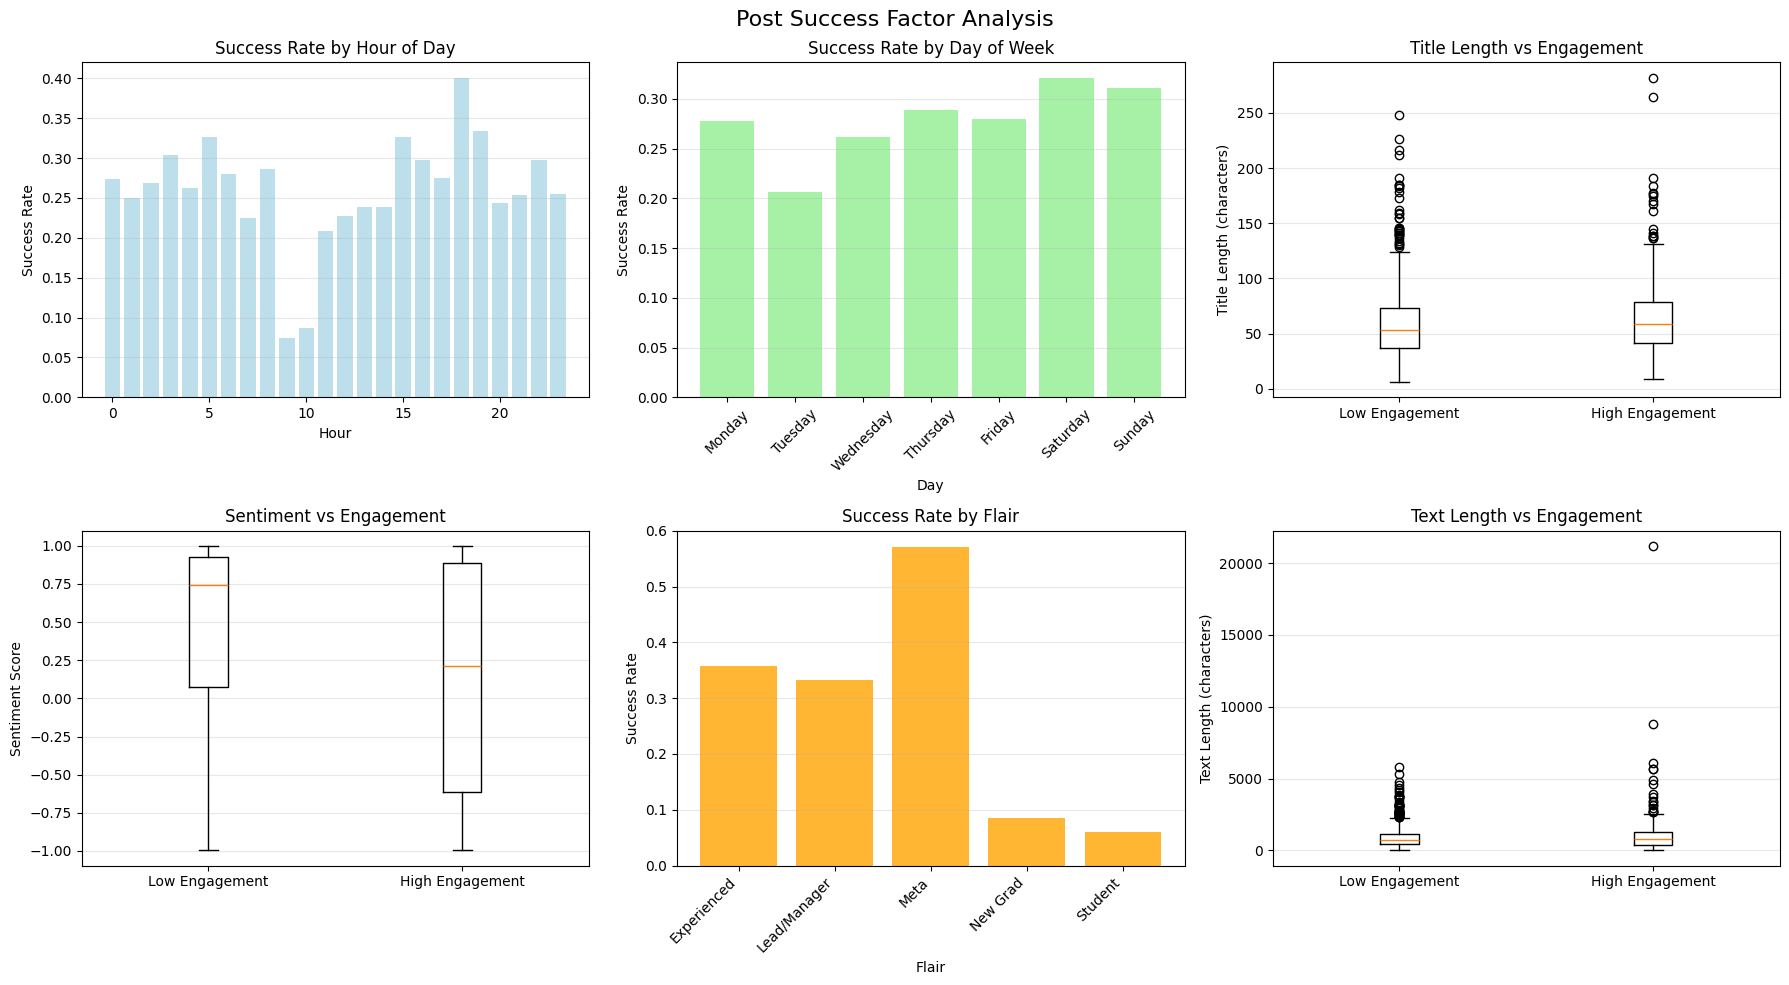


📊 SUCCESS INSIGHTS:
Best hour to post: 18:00 (40.0% success rate)
Best day to post: Saturday (32.1% success rate)
Average sentiment - Successful posts: 0.135 vs All posts: 0.371


In [78]:
if posts_df is not None and len(posts_df) > 0:
    print("ANALYZING POST SUCCESS FACTORS")
    print("=" * 50)
    
    # Define success metrics
    posts_df['high_score'] = posts_df['score'] > posts_df['score'].quantile(0.75)
    posts_df['high_comments'] = posts_df['num_comments'] > posts_df['num_comments'].quantile(0.75)
    posts_df['high_engagement'] = posts_df['high_score'] | posts_df['high_comments']
    
    successful_posts = posts_df[posts_df['high_engagement']]
    
    print(f"High-performing posts: {len(successful_posts)} ({len(successful_posts)/len(posts_df)*100:.1f}%)")
    
    # Analyze success factors
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Post Success Factor Analysis', fontsize=16)
    
    # Success by hour
    success_by_hour = posts_df.groupby('hour')['high_engagement'].mean()
    axes[0, 0].bar(success_by_hour.index, success_by_hour.values, color='lightblue', alpha=0.8)
    axes[0, 0].set_title('Success Rate by Hour of Day')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Success Rate')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Success by day of week
    success_by_day = posts_df.groupby('day_of_week')['high_engagement'].mean()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    success_by_day_ordered = success_by_day.reindex(day_order)
    
    axes[0, 1].bar(range(len(success_by_day_ordered)), success_by_day_ordered.values, color='lightgreen', alpha=0.8)
    axes[0, 1].set_title('Success Rate by Day of Week')
    axes[0, 1].set_xlabel('Day')
    axes[0, 1].set_ylabel('Success Rate')
    axes[0, 1].set_xticks(range(len(day_order)))
    axes[0, 1].set_xticklabels(day_order, rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Title length vs success
    axes[0, 2].boxplot([posts_df[~posts_df['high_engagement']]['title_length'],
                        posts_df[posts_df['high_engagement']]['title_length']],
                        labels=['Low Engagement', 'High Engagement'])
    axes[0, 2].set_title('Title Length vs Engagement')
    axes[0, 2].set_ylabel('Title Length (characters)')
    axes[0, 2].grid(axis='y', alpha=0.3)
    
    # Sentiment vs success
    if 'compound' in posts_df.columns:
        axes[1, 0].boxplot([posts_df[~posts_df['high_engagement']]['compound'],
                            posts_df[posts_df['high_engagement']]['compound']],
                            labels=['Low Engagement', 'High Engagement'])
        axes[1, 0].set_title('Sentiment vs Engagement')
        axes[1, 0].set_ylabel('Sentiment Score')
        axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Success by flair (if available)
    if posts_df['flair'].notna().sum() > 10:
        flair_success = posts_df.groupby('flair')['high_engagement'].agg(['count', 'mean']).reset_index()
        flair_success = flair_success[flair_success['count'] >= 5]  # Only flairs with 5+ posts
        
        if len(flair_success) > 0:
            axes[1, 1].bar(range(len(flair_success)), flair_success['mean'], color='orange', alpha=0.8)
            axes[1, 1].set_title('Success Rate by Flair')
            axes[1, 1].set_xlabel('Flair')
            axes[1, 1].set_ylabel('Success Rate')
            axes[1, 1].set_xticks(range(len(flair_success)))
            axes[1, 1].set_xticklabels(flair_success['flair'], rotation=45, ha='right')
            axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Text length vs success (for posts with text)
    posts_with_text = posts_df[posts_df['text_length'] > 0]
    if len(posts_with_text) > 20:
        axes[1, 2].boxplot([posts_with_text[~posts_with_text['high_engagement']]['text_length'],
                            posts_with_text[posts_with_text['high_engagement']]['text_length']],
                            labels=['Low Engagement', 'High Engagement'])
        axes[1, 2].set_title('Text Length vs Engagement')
        axes[1, 2].set_ylabel('Text Length (characters)')
        axes[1, 2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print success insights
    best_hour = success_by_hour.idxmax()
    best_day = success_by_day_ordered.idxmax()
    
    print(f"\n📊 SUCCESS INSIGHTS:")
    print(f"Best hour to post: {best_hour}:00 ({success_by_hour[best_hour]:.1%} success rate)")
    print(f"Best day to post: {best_day} ({success_by_day_ordered[best_day]:.1%} success rate)")
    
    if 'compound' in posts_df.columns:
        avg_sentiment_successful = successful_posts['compound'].mean()
        avg_sentiment_all = posts_df['compound'].mean()
        print(f"Average sentiment - Successful posts: {avg_sentiment_successful:.3f} vs All posts: {avg_sentiment_all:.3f}")


# 7) Comprehensive Summary Report

In [79]:
if posts_df is not None and len(posts_df) > 0:
    print("=" * 60)
    print("📋 COMPREHENSIVE SUMMARY REPORT")
    print("r/cscareerquestions Analysis")
    print("=" * 60)
    
    # Dataset overview
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total posts analyzed: {len(posts_df):,}")
    print(f"   • Date range: {posts_df['created_utc'].min().strftime('%Y-%m-%d')} to {posts_df['created_utc'].max().strftime('%Y-%m-%d')}")
    print(f"   • Unique authors: {posts_df['author'].nunique():,}")
    print(f"   • Posts with text content: {(posts_df['text_length'] > 0).sum()} ({(posts_df['text_length'] > 0).mean()*100:.1f}%)")
    
    # Engagement metrics
    print(f"\n🔥 ENGAGEMENT METRICS:")
    print(f"   • Average score: {posts_df['score'].mean():.1f}")
    print(f"   • Median score: {posts_df['score'].median():.1f}")
    print(f"   • Average comments: {posts_df['num_comments'].mean():.1f}")
    print(f"   • Average upvote ratio: {posts_df['upvote_ratio'].mean():.3f}")
    print(f"   • Score-Comments correlation: {posts_df['score'].corr(posts_df['num_comments']):.3f}")
    
    # Temporal patterns
    peak_hour = posts_df['hour'].mode()[0]
    peak_day = posts_df['day_of_week'].mode()[0]
    print(f"\n⏰ TEMPORAL PATTERNS:")
    print(f"   • Peak posting hour: {peak_hour}:00")
    print(f"   • Most active day: {peak_day}")
    
    # Sentiment analysis (if available)
    if 'compound' in posts_df.columns:
        positive_posts = len(posts_df[posts_df['compound'] > 0.05])
        negative_posts = len(posts_df[posts_df['compound'] < -0.05])
        neutral_posts = len(posts_df) - positive_posts - negative_posts
        
        print(f"\n😊 SENTIMENT ANALYSIS:")
        print(f"   • Average sentiment: {posts_df['compound'].mean():.3f}")
        print(f"   • Positive posts: {positive_posts} ({positive_posts/len(posts_df)*100:.1f}%)")
        print(f"   • Negative posts: {negative_posts} ({negative_posts/len(posts_df)*100:.1f}%)")
        print(f"   • Neutral posts: {neutral_posts} ({neutral_posts/len(posts_df)*100:.1f}%)")
    
    # Text insights
    print(f"\n📝 TEXT INSIGHTS:")
    print(f"   • Average title length: {posts_df['title_length'].mean():.0f} characters")
    if posts_df['text_length'].max() > 0:
        text_with_content = posts_df[posts_df['text_length'] > 0]['text_length']
        print(f"   • Average post length: {text_with_content.mean():.0f} characters")
    
    # Top keywords
    if len(title_words) > 0:
        print(f"\n🔤 TOP KEYWORDS IN TITLES:")
        for word, count in title_counter.most_common(8):
            print(f"   • {word}: {count}")
    
    # Career topics
    if 'topic_counts' in locals():
        print(f"\n💼 TOP CAREER TOPICS:")
        sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
        for topic, count in sorted_topics[:5]:
            percentage = (count / len(posts_df)) * 100
            print(f"   • {topic}: {count} mentions ({percentage:.1f}% of posts)")
    
    # Success factors (if analyzed)
    if 'high_engagement' in posts_df.columns:
        print(f"\n🎯 SUCCESS FACTORS:")
        if 'best_hour' in locals():
            print(f"   • Best time to post: {best_day}s at {best_hour}:00")
        
        successful_posts = posts_df[posts_df['high_engagement']]
        print(f"   • High-engagement posts: {len(successful_posts)} ({len(successful_posts)/len(posts_df)*100:.1f}%)")
        
        if 'compound' in posts_df.columns:
            sentiment_score_corr = posts_df['compound'].corr(posts_df['score'])
            if sentiment_score_corr > 0.1:
                print("   • Positive sentiment correlates with higher engagement")
            elif sentiment_score_corr < -0.1:
                print("   • Negative posts tend to get more attention")
    
    # Recommendations
    print(f"\n💡 KEY RECOMMENDATIONS:")
    if 'peak_hour' in locals() and 'peak_day' in locals():
        print(f"   • Post on {peak_day}s around {peak_hour}:00 for maximum visibility")
    print("   • Focus on job search, interview, and salary topics for engagement")
    print("   • Ask specific questions to encourage discussion")
    if 'compound' in posts_df.columns and posts_df['compound'].mean() < 0:
        print("   • Consider more positive framing of questions/advice")
    print("   • Use descriptive titles (avoid too short or too long)")
    
    print("\n" + "=" * 60)
    print("✅ Analysis Complete!")

📋 COMPREHENSIVE SUMMARY REPORT
r/cscareerquestions Analysis

📊 DATASET OVERVIEW:
   • Total posts analyzed: 1,230
   • Date range: 2024-09-26 to 2025-09-25
   • Unique authors: 996
   • Posts with text content: 1230 (100.0%)

🔥 ENGAGEMENT METRICS:
   • Average score: 340.0
   • Median score: 5.0
   • Average comments: 90.4
   • Average upvote ratio: 0.730
   • Score-Comments correlation: 0.853

⏰ TEMPORAL PATTERNS:
   • Peak posting hour: 0:00
   • Most active day: Wednesday

😊 SENTIMENT ANALYSIS:
   • Average sentiment: 0.371
   • Positive posts: 850 (69.1%)
   • Negative posts: 327 (26.6%)
   • Neutral posts: 53 (4.3%)

📝 TEXT INSIGHTS:
   • Average title length: 60 characters
   • Average post length: 951 characters

🔤 TOP KEYWORDS IN TITLES:
   • job: 161
   • tech: 81
   • get: 74
   • career: 70
   • advice: 61
   • new: 60
   • need: 49
   • jobs: 47

💼 TOP CAREER TOPICS:
   • Job Search: 1777 mentions (144.5% of posts)
   • Company Types: 1266 mentions (102.9% of posts)
   • Ex

### 7.2) Save the analyzed data and create export files


In [80]:
if posts_df is not None and len(posts_df) > 0:
    print("💾 SAVING ANALYSIS RESULTS...")
    
    # Save main dataset
    posts_df.to_csv('cscareerquestions_posts_analyzed.csv', index=False)
    print("✅ Main dataset saved as 'cscareerquestions_posts_analyzed.csv'")
    
    # Create summary statistics file
    summary_stats = {
        'total_posts': len(posts_df),
        'date_range_start': posts_df['created_utc'].min().strftime('%Y-%m-%d'),
        'date_range_end': posts_df['created_utc'].max().strftime('%Y-%m-%d'),
        'avg_score': posts_df['score'].mean(),
        'avg_comments': posts_df['num_comments'].mean(),
        'avg_upvote_ratio': posts_df['upvote_ratio'].mean(),
        'peak_hour': posts_df['hour'].mode()[0],
        'peak_day': posts_df['day_of_week'].mode()[0]
    }
    
    if 'compound' in posts_df.columns:
        summary_stats['avg_sentiment'] = posts_df['compound'].mean()
        summary_stats['positive_posts_pct'] = (posts_df['compound'] > 0.05).mean() * 100
        summary_stats['negative_posts_pct'] = (posts_df['compound'] < -0.05).mean() * 100
    
    # Save summary as JSON
    import json
    with open('analysis_summary.json', 'w') as f:
        json.dump(summary_stats, f, indent=2, default=str)
    print("✅ Summary statistics saved as 'analysis_summary.json'")
    
    # Save top posts
    top_posts_export = posts_df.nlargest(20, 'score')[['title', 'score', 'num_comments', 'created_utc', 'author']]
    top_posts_export.to_csv('top_posts.csv', index=False)
    print("✅ Top 20 posts saved as 'top_posts.csv'")
    
    print(f"\n🎉 Analysis complete! Files saved:")
    print(f"   • cscareerquestions_posts_analyzed.csv ({len(posts_df)} posts)")
    print(f"   • analysis_summary.json (key metrics)")
    print(f"   • top_posts.csv (top 20 posts)")
    
    # Final data info
    print(f"\n📋 FINAL DATASET INFO:")
    print(f"   Columns: {list(posts_df.columns)}")
    print(f"   Memory usage: {posts_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
else:
    print("❌ No data to save. Please run the data extraction first.")

print("\n" + "="*60)
print("🎊 REDDIT EDA ANALYSIS COMPLETE!")
print("Thank you for using this analysis notebook!")
print("="*60)

💾 SAVING ANALYSIS RESULTS...
✅ Main dataset saved as 'cscareerquestions_posts_analyzed.csv'
✅ Summary statistics saved as 'analysis_summary.json'
✅ Top 20 posts saved as 'top_posts.csv'

🎉 Analysis complete! Files saved:
   • cscareerquestions_posts_analyzed.csv (1230 posts)
   • analysis_summary.json (key metrics)
   • top_posts.csv (top 20 posts)

📋 FINAL DATASET INFO:
   Columns: ['id', 'title', 'text', 'score', 'upvote_ratio', 'num_comments', 'created_utc', 'author', 'flair', 'url', 'is_self', 'gilded', 'stickied', 'locked', 'hour', 'day_of_week', 'date', 'month', 'comments_per_score', 'engagement_ratio', 'combined_text', 'title_length', 'text_length', 'combined_length', 'neg', 'neu', 'pos', 'compound', 'sentiment_category', 'high_score', 'high_comments', 'high_engagement']
   Memory usage: 4.4 MB

🎊 REDDIT EDA ANALYSIS COMPLETE!
Thank you for using this analysis notebook!
